# DenseNet 121

- Paper: [2016.08.25] Densely Connected Convolutional Networks
- https://arxiv.org/abs/1608.06993

### [Package load]

In [ ]:
import torch 
print('pytorch version: {}'.format(torch.__version__))

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

### [Model: DenseNet121]

- https://github.com/pytorch/vision/blob/main/torchvision/models/densenet.py

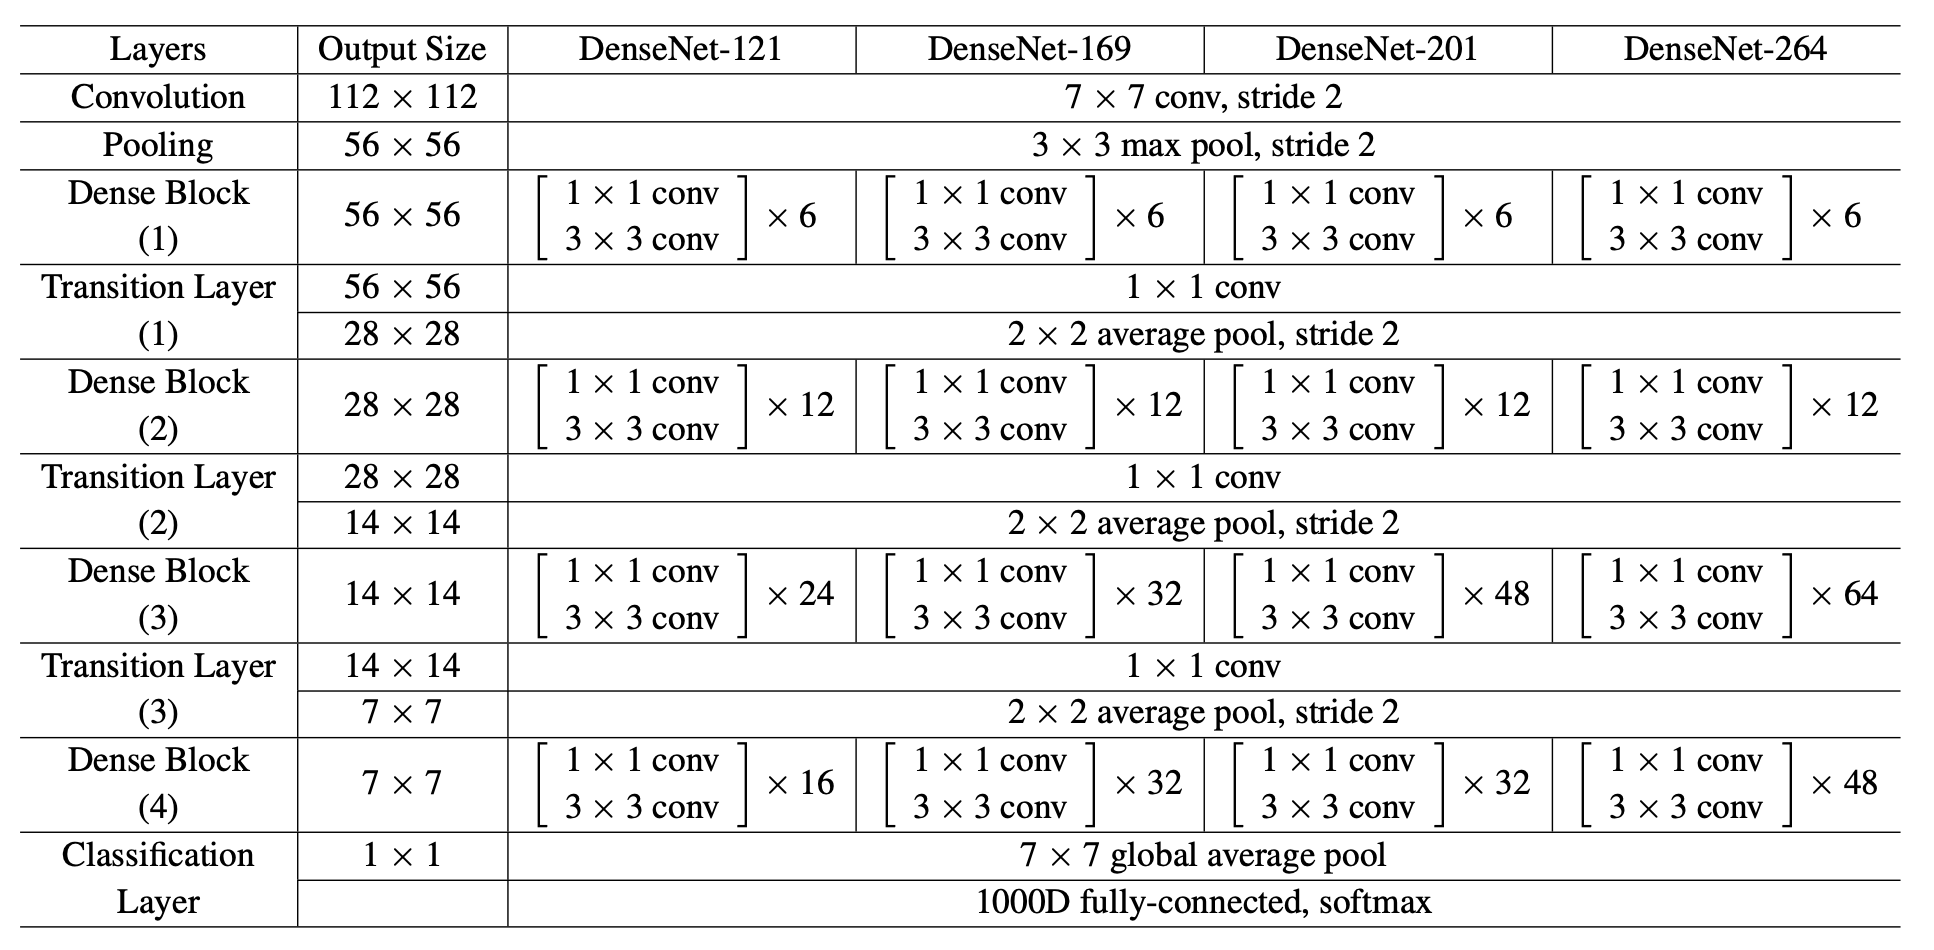

In [ ]:
class BottleneckLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, dropout_rate):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size*growth_rate, kernel_size=1, stride=1, bias=False)
            # num_input_features -> 1x1 conv -> bn_size*growth_rate로 channel 변경
        self.bn2 = nn.BatchNorm2d(bn_size*growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size*growth_rate, growth_rate, kernel_size=3, padding=1, stride=1, bias=False)
            # bn_size*growth_rate -> 3x3 conv -> growth_rate로 channel 변경

        self.dropout_rate = dropout_rate
    
    def forward(self, input):
        output = self.conv1(self.relu1(self.bn1(input)))
        output = self.conv2(self.relu2(self.bn2(output)))
        if self.dropout_rate>0:
            output = F.dropout(output, p=self.dropout_rate, training = self.training)
        output = torch.cat((input, output), 1)
        return output


class DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, growth_rate, bn_size, dropout_rate):
        super().__init__()
        for i in range(num_layers):
            layer = BottleneckLayer(num_input_features=num_input_features+i*growth_rate, growth_rate=growth_rate,
                                    bn_size=bn_size, dropout_rate=dropout_rate)
            self.add_module("denselayer%d" %(i+1), layer)
    
    def forward(self, x):
        for c in self.children():
            x = c(x)
        return x


class Transition(nn.Module):
    def __init__(self, num_input_features, theta=0.5):  # theta는 output channel을 얼마나 줄일지 정하는 hyperparameter
        super().__init__()
        self.bn = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(num_input_features, int(num_input_features*theta), kernel_size=1, stride=1, bias=False)   # 1x1 conv
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
    
    def forward(self, input):
        output = self.pool(self.conv(self.relu(self.bn(input))))
        return output


'''처음 Conv (1) + 1st Denseblock (6*2 = 12) + Transition (1) + 2nd Denseblock (12*2 = 24) + Transition (1)
 + 3rd Denseblock (24*2 = 48) + Transition (1) + 4th Denseblock (16*2 = 32) + Classification (1) = 121 layer 
'''
from collections import OrderedDict

class DenseNet(nn.Module):
    def __init__(self, growth_rate=32,block_config=(6, 12, 24, 16),num_init_features=64,bn_size=4,theta=0.5,drop_rate=0,num_classes=1000):
        super().__init__()
        # 1st Conv
        self.features = nn.Sequential(
            OrderedDict(
                [
                    ("conv0", nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
                    ("norm0", nn.BatchNorm2d(num_init_features)),
                    ("relu0", nn.ReLU(inplace=True)),
                    ("pool0", nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
                ]
            )
        )

        # Denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(num_layers=num_layers, num_input_features=num_features, growth_rate=growth_rate, bn_size=bn_size, dropout_rate=drop_rate)
            self.features.add_module("Denseblock%d"%(i+1), block)
            num_features = num_features + num_layers*growth_rate
            if i != len(block_config)-1:    #Denseblock 사이에 transition 끼워넣기
                transition = Transition(num_input_features=num_features, theta=theta)
                self.features.add_module("Transition%d" % (i + 1), transition)
                num_features = num_features // 2 #theta가 0.5기 때문

        # Final batch norm
        self.features.add_module("norm5", nn.BatchNorm2d(num_features))
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [ ]:
densenet121 = DenseNet(num_classes=4).to(device)

In [ ]:
densenet121

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (Denseblock1): DenseBlock(
      (denselayer1): BottleneckLayer(
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): BottleneckLayer(
        (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
temp = torch.Tensor(np.random.randint(1, 255, size=(1, 3, 224, 224)))
densenet121(temp)

tensor([[ 0.4987, -0.3693,  0.6487, -0.0810]], grad_fn=<AddmmBackward0>)

In [ ]:
from torchsummary import summary
summary(densenet121, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]           8,192
       BatchNorm2d-8          [-1, 128, 56, 56]             256
              ReLU-9          [-1, 128, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          36,864
  BottleneckLayer-11           [-1, 96, 56, 56]               0
      BatchNorm2d-12           [-1, 96, 56, 56]             192
             ReLU-13           [-1, 96, 56, 56]               0
           Conv2d-14          [-1, 128,

In [ ]:
from torchinfo import summary
summary(densenet121, input_size=(1, 3, 224, 224), col_width=20, depth=121, row_settings=["depth", "var_names"], col_names=["input_size", "kernel_size", "output_size", "params_percent"])

Layer (type (var_name):depth-idx)                       Input Shape          Kernel Shape         Output Shape         Param %
DenseNet (DenseNet)                                     [1, 3, 224, 224]     --                   [1, 4]                    --
├─Sequential (features): 1-1                            [1, 3, 224, 224]     --                   [1, 1024, 7, 7]           --
│    └─Conv2d (conv0): 2-1                              [1, 3, 224, 224]     [7, 7]               [1, 64, 112, 112]      0.14%
│    └─BatchNorm2d (norm0): 2-2                         [1, 64, 112, 112]    --                   [1, 64, 112, 112]      0.00%
│    └─ReLU (relu0): 2-3                                [1, 64, 112, 112]    --                   [1, 64, 112, 112]         --
│    └─MaxPool2d (pool0): 2-4                           [1, 64, 112, 112]    3                    [1, 64, 56, 56]           --
│    └─DenseBlock (Denseblock1): 2-5                    [1, 64, 56, 56]      --                   [1, 256, 56, 

### [Model: DenseNet121 Transfer Learning]

In [ ]:
class TransferDenseNet(nn.Module):
    def __init__ (self, num_classes):
        super(TransferDenseNet, self).__init__()
        self.densenet = torchvision.models.densenet121(pretrained=True)
        num_feature = torchvision.models.densenet121(pretrained=True).classifier.in_features
        self.densenet.classifier = nn.Linear(num_feature, num_classes)
        
    def forward(self,x):
        return self.densenet(x)

In [ ]:
densenet121_transfer = TransferDenseNet(num_classes=4).to(device)

c:\ProgramData\miniconda3\envs\for_learning\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\miniconda3\envs\for_learning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
temp = torch.Tensor(np.random.randint(1, 255, size=(1, 3, 224, 224)))
densenet121_transfer(temp)

tensor([[-0.3825,  0.7296,  0.2868,  0.5038]], grad_fn=<AddmmBackward0>)

In [ ]:
densenet121_transfer

TransferDenseNet(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mo

In [ ]:
'''from torchsummary import summary
summary(densenet121_transfer, (3, 224, 224))'''
# skip d/t error -> need to use torchsummaryX

In [ ]:
from torchinfo import summary
summary(densenet121_transfer, input_size=(1, 3, 224, 224), col_width=20, depth=121, row_settings=["depth", "var_names"], col_names=["input_size", "kernel_size", "output_size", "params_percent"])

Layer (type (var_name):depth-idx)                       Input Shape          Kernel Shape         Output Shape         Param %
TransferDenseNet (TransferDenseNet)                     [1, 3, 224, 224]     --                   [1, 4]                    --
├─DenseNet (densenet): 1-1                              [1, 3, 224, 224]     --                   [1, 4]                    --
│    └─Sequential (features): 2-1                       [1, 3, 224, 224]     --                   [1, 1024, 7, 7]           --
│    │    └─Conv2d (conv0): 3-1                         [1, 3, 224, 224]     [7, 7]               [1, 64, 112, 112]      0.14%
│    │    └─BatchNorm2d (norm0): 3-2                    [1, 64, 112, 112]    --                   [1, 64, 112, 112]      0.00%
│    │    └─ReLU (relu0): 3-3                           [1, 64, 112, 112]    --                   [1, 64, 112, 112]         --
│    │    └─MaxPool2d (pool0): 3-4                      [1, 64, 112, 112]    3                    [1, 64, 56, 5

In [ ]:
count = 0
for name, param in densenet121_transfer.named_parameters():
    count += 1
    print(f"count:{count},",name, param.requires_grad)

count:1, densenet.features.conv0.weight True
count:2, densenet.features.norm0.weight True
count:3, densenet.features.norm0.bias True
count:4, densenet.features.denseblock1.denselayer1.norm1.weight True
count:5, densenet.features.denseblock1.denselayer1.norm1.bias True
count:6, densenet.features.denseblock1.denselayer1.conv1.weight True
count:7, densenet.features.denseblock1.denselayer1.norm2.weight True
count:8, densenet.features.denseblock1.denselayer1.norm2.bias True
count:9, densenet.features.denseblock1.denselayer1.conv2.weight True
count:10, densenet.features.denseblock1.denselayer2.norm1.weight True
count:11, densenet.features.denseblock1.denselayer2.norm1.bias True
count:12, densenet.features.denseblock1.denselayer2.conv1.weight True
count:13, densenet.features.denseblock1.denselayer2.norm2.weight True
count:14, densenet.features.denseblock1.denselayer2.norm2.bias True
count:15, densenet.features.denseblock1.denselayer2.conv2.weight True
count:16, densenet.features.denseblock1.d

In [ ]:
# Denseblock 4의 required_grad True로 바꾸기 (Layer 4의 시작: 265) -> 265 이전은 false, 이후는 True
count = 0
for param in densenet121_transfer.densenet.parameters():
    count += 1
    if count >= 265:
        param.requires_grad = True
    else:
        param.requires_grad = False

for name, param in densenet121_transfer.named_parameters():
    print(name, param.requires_grad)

densenet.features.conv0.weight False
densenet.features.norm0.weight False
densenet.features.norm0.bias False
densenet.features.denseblock1.denselayer1.norm1.weight False
densenet.features.denseblock1.denselayer1.norm1.bias False
densenet.features.denseblock1.denselayer1.conv1.weight False
densenet.features.denseblock1.denselayer1.norm2.weight False
densenet.features.denseblock1.denselayer1.norm2.bias False
densenet.features.denseblock1.denselayer1.conv2.weight False
densenet.features.denseblock1.denselayer2.norm1.weight False
densenet.features.denseblock1.denselayer2.norm1.bias False
densenet.features.denseblock1.denselayer2.conv1.weight False
densenet.features.denseblock1.denselayer2.norm2.weight False
densenet.features.denseblock1.denselayer2.norm2.bias False
densenet.features.denseblock1.denselayer2.conv2.weight False
densenet.features.denseblock1.denselayer3.norm1.weight False
densenet.features.denseblock1.denselayer3.norm1.bias False
densenet.features.denseblock1.denselayer3.conv1

In [ ]:
# Denseblock 4의 Conv layer를 다시 initialization
for name, layer in densenet121_transfer.densenet.features.named_children():
    if name == 'denseblock4':
        denselayer_index = 1
        conv_index = 1
        for name, param in densenet121_transfer.densenet.features.named_parameters():
            # Layer 4의 Conv layer parameter initialization
            if name == 'denseblock4.denselayer'+str(denselayer_index)+'.conv'+str(conv_index)+'.weight':
                print('denseblock4의 '+str(denselayer_index)+'번째 denselayer의 conv'+str(conv_index)+'.weight')
                nn.init.xavier_uniform_(param)
                print(name+'의 conv filter initialization setting 완료')
                print()
                conv_index += 1
                if name == 'denseblock4.denselayer'+str(denselayer_index)+'.conv2.weight':
                    denselayer_index += 1
                    conv_index = 1

denseblock4의 1번째 denselayer의 conv1.weight
denseblock4.denselayer1.conv1.weight의 conv filter initialization setting 완료

denseblock4의 1번째 denselayer의 conv2.weight
denseblock4.denselayer1.conv2.weight의 conv filter initialization setting 완료

denseblock4의 2번째 denselayer의 conv1.weight
denseblock4.denselayer2.conv1.weight의 conv filter initialization setting 완료

denseblock4의 2번째 denselayer의 conv2.weight
denseblock4.denselayer2.conv2.weight의 conv filter initialization setting 완료

denseblock4의 3번째 denselayer의 conv1.weight
denseblock4.denselayer3.conv1.weight의 conv filter initialization setting 완료

denseblock4의 3번째 denselayer의 conv2.weight
denseblock4.denselayer3.conv2.weight의 conv filter initialization setting 완료

denseblock4의 4번째 denselayer의 conv1.weight
denseblock4.denselayer4.conv1.weight의 conv filter initialization setting 완료

denseblock4의 4번째 denselayer의 conv2.weight
denseblock4.denselayer4.conv2.weight의 conv filter initialization setting 완료

denseblock4의 5번째 denselayer의 conv1.weight
denseb

In [ ]:
# Denseblock 4의 batch normalization gamma, beta initialization
# 전부 initialization시키므로 처음 시작을 0, 1로 시작, 만약 좀 더 뒤로 바꾸고 싶으면 초기 시작 값을 바꾸기
# Denseblock 4에서 4의 배수에 해당하는 denselayer의 batch norm 2의 gamma는 0로, 나머지는 1로 초기화시키기
denselayer_index = 1
bn_index = 1
for name, param in densenet121_transfer.densenet.features.named_parameters():
    if denselayer_index % 4 == 0:
        if name == 'denseblock4.denselayer'+str(denselayer_index)+'.norm1.weight':
            print('denseblock4의 '+str(denselayer_index)+'번째 denselayer의 '+'norm1.weight')
            nn.init.ones_(param)
            print(name+'의 gamma one setting 완료')
            print()
        elif name == 'denseblock4.denselayer'+str(denselayer_index)+'.norm2.weight':
            print('denseblock4의 '+str(denselayer_index)+'번째 denselayer의 '+'norm2.weight')
            nn.init.zeros_(param)
            print(name+'의 gamma zero setting 완료')
            print()
        elif name == 'denseblock4.denselayer'+str(denselayer_index)+'.'+'norm'+str(bn_index)+'.bias':
            print('denseblock4.denselayer'+str(denselayer_index)+'.'+'norm'+str(bn_index)+'.bias')     # bias는 0으로 초기화
            nn.init.zeros_(param)
            print(name+'의 beta zero setting 완료')
            print()
            if bn_index == 2:
                bn_index=1
                denselayer_index += 1
                continue
            bn_index += 1
    else:
        if name == 'denseblock4.denselayer'+str(denselayer_index)+'.norm1.weight':
            print('denseblock4의 '+str(denselayer_index)+'번째 denselayer의 '+'norm1.weight')
            nn.init.ones_(param)
            print(name+'의 gamma one setting 완료')
            print()
        elif name == 'denseblock4.denselayer'+str(denselayer_index)+'.norm2.weight':
            print('denseblock4의 '+str(denselayer_index)+'번째 denselayer의 '+'norm2.weight')
            nn.init.ones_(param)
            print(name+'의 gamma one setting 완료')
            print()
        elif name == 'denseblock4.denselayer'+str(denselayer_index)+'.'+'norm'+str(bn_index)+'.bias':
            print('denseblock4.denselayer'+str(denselayer_index)+'.'+'norm'+str(bn_index)+'.bias')     # bias는 0으로 초기화
            nn.init.zeros_(param)
            print(name+'의 beta zero setting 완료')
            print()
            if bn_index == 2:
                bn_index=1
                denselayer_index += 1
                continue
            bn_index += 1

denseblock4의 1번째 denselayer의 norm1.weight
denseblock4.denselayer1.norm1.weight의 gamma one setting 완료

denseblock4.denselayer1.norm1.bias
denseblock4.denselayer1.norm1.bias의 beta zero setting 완료

denseblock4의 1번째 denselayer의 norm2.weight
denseblock4.denselayer1.norm2.weight의 gamma one setting 완료

denseblock4.denselayer1.norm2.bias
denseblock4.denselayer1.norm2.bias의 beta zero setting 완료

denseblock4의 2번째 denselayer의 norm1.weight
denseblock4.denselayer2.norm1.weight의 gamma one setting 완료

denseblock4.denselayer2.norm1.bias
denseblock4.denselayer2.norm1.bias의 beta zero setting 완료

denseblock4의 2번째 denselayer의 norm2.weight
denseblock4.denselayer2.norm2.weight의 gamma one setting 완료

denseblock4.denselayer2.norm2.bias
denseblock4.denselayer2.norm2.bias의 beta zero setting 완료

denseblock4의 3번째 denselayer의 norm1.weight
denseblock4.denselayer3.norm1.weight의 gamma one setting 완료

denseblock4.denselayer3.norm1.bias
denseblock4.denselayer3.norm1.bias의 beta zero setting 완료

denseblock4의 3번째 denselay